In [1]:
!nvidia-smi -L

GPU 0: NVIDIA A100-SXM4-40GB (UUID: GPU-41c0004c-792f-9231-481c-96acfac687e1)
GPU 1: NVIDIA A100-SXM4-40GB (UUID: GPU-5ba48061-73d7-68f5-c2b5-3fe1d41787a9)
GPU 2: NVIDIA A100-SXM4-40GB (UUID: GPU-be05d4b7-69e5-4ce7-f504-da16bfdb568a)
  MIG 7g.40gb     Device  0: (UUID: MIG-dcb42887-dacb-5eaa-9cf2-4268298af7d2)
GPU 3: NVIDIA A100-SXM4-40GB (UUID: GPU-82cb75c9-59f1-e184-b501-cc559c8d5073)
GPU 4: NVIDIA A100-SXM4-40GB (UUID: GPU-b0fc60a3-9b11-e6d1-8022-4abb184599b3)
GPU 5: NVIDIA A100-SXM4-40GB (UUID: GPU-472ad957-6605-bc15-09f4-ecc3afba0fe2)
GPU 6: NVIDIA A100-SXM4-40GB (UUID: GPU-5989ddde-a91e-a5d6-8985-8398adc205a5)
GPU 7: NVIDIA A100-SXM4-40GB (UUID: GPU-14554570-e7cc-ca3b-f394-afc3fc4ba63a)


In [2]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import seaborn as sns
from skimage import color
from skimage import transform
from skimage import io, filters
import matplotlib.pyplot as plt
from skimage.filters import frangi
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.layers import Flatten
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from tensorflow.keras.layers import BatchNormalization
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator, array_to_img

2024-03-31 13:13:44.452752: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9373] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-31 13:13:44.452801: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-31 13:13:44.453538: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1534] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-31 13:13:44.459059: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Start Here

In [3]:
main_folders = [
    r"images_cropped_frangi",
    r"images_cropped_frangi_augmented",
]

# List all JPEG files in the main folder and its subfolders
jpeg_files = []
for main_folder in main_folders:
    for root, dirs, files in os.walk(main_folder):
        for file in files:
            if file.endswith(".jpg"):
                jpeg_files.append(os.path.join(root, file))

# Create a list to store the data
data = []

# Display the names of JPEG files
for jpeg_path in jpeg_files:
    # Display the full path of the JPEG file
    # print(jpeg_path)

    # Split the path to extract labels
    name_parts = jpeg_path.split(os.sep)

    # Store the data in a dictionary
    image_data = {
        "ImagePath": jpeg_path,
        "label": name_parts[1],
        "patient": name_parts[2],
    }

    # Append the data to the list
    data.append(image_data)

# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(data)

# Display the DataFrame
df.sample(5)

,ImagePath,label,patient
4459,images_cropped_frangi_augmented/Prodromal PD/0...,Prodromal PD,027
6870,images_cropped_frangi_augmented/Healthy Contro...,Healthy Control,033
1864,images_cropped_frangi_augmented/PD/041/+kitsan...,PD,041
1186,images_cropped_frangi_augmented/PD/037/+Saetan...,PD,037
5102,images_cropped_frangi_augmented/Prodromal PD/5...,Prodromal PD,52


In [4]:
len(df)

8320

In [5]:
# Function to display images with titles
def display_images(dataframe, num_images):
    # Select random rows from the DataFrame
    random_indices = random.sample(range(len(dataframe)), num_images)

    # Create subplots
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    # Original images
    for i, idx in enumerate(random_indices):
        # Read the image using OpenCV
        img = cv2.imread(dataframe.loc[idx, "ImagePath"])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        # img = img[:-100, :, :]
        # Display the image
        axes[i].imshow(img)
        # Set the title as L1 label
        axes[i].set_title(dataframe.loc[idx, "label"])
        # Remove axis ticks
        axes[i].axis("off")
    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

    # Create subplots
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    # Applied Frangi filter images
    for i, idx in enumerate(random_indices):
        # print(random_indices)
        # Read the image using OpenCV
        input_imagef = io.imread(dataframe.loc[idx, "ImagePath"])
        if len(input_imagef.shape) != 2:
            # If the image has three dimensions, it's not grayscale
            input_imagef = color.rgb2gray(input_imagef)

        else:
            input_imagef = input_imagef

        # Create a range of sigma values from 0.5 to 3 with an increment of 0.5
        sigmas_range = np.arange(0.25, 6, 0.5)
        # Create a list to store the filtered images
        filtered_images = []
        # Loop through the sigma values
        for sigma in sigmas_range:
            # Apply the Frangi filter for the current sigma
            filtered_image = frangi(
                input_imagef,
                sigmas=(sigma, sigma),  # Use the current sigma for both dimensions
                scale_step=1,
                black_ridges=False,
            )

        filtered_images.append(filtered_image)
        # Create a combined image by taking the maximum value across all filtered images
        filtered_image = np.max(filtered_images, axis=0)
        # Rescale the pixel values to the range [0, 255]
        min_val = filtered_image.min()
        max_val = filtered_image.max()
        scaled_image = (filtered_image - min_val) / (max_val - min_val) * 255
        # Check if the image has a single channel
        axes[i].imshow(scaled_image)
        # Set the title as L1 label
        axes[i].set_title(dataframe.loc[idx, "label"])
        # Remove axis ticks
        axes[i].axis("off")
    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

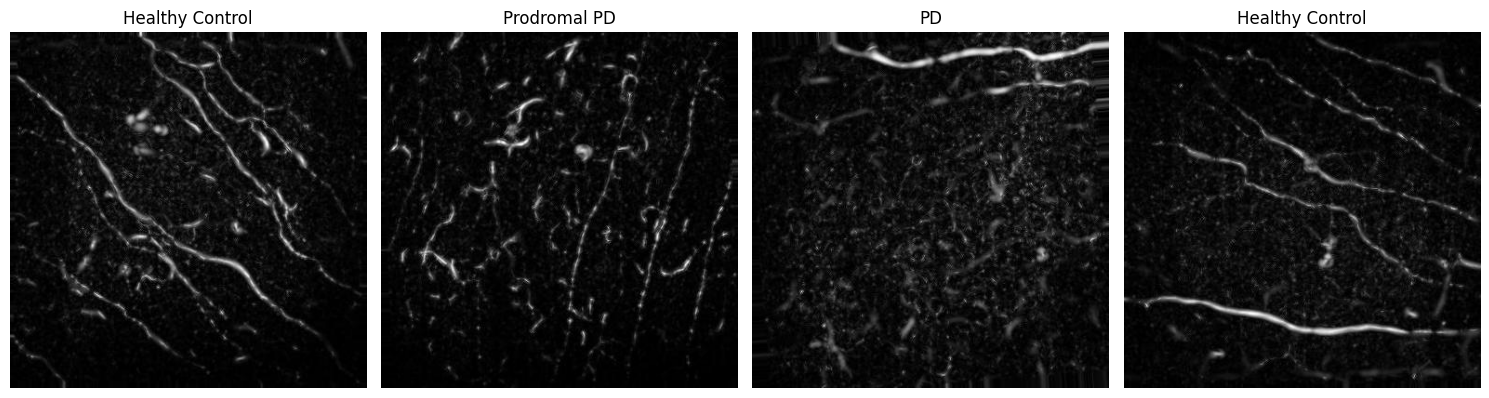

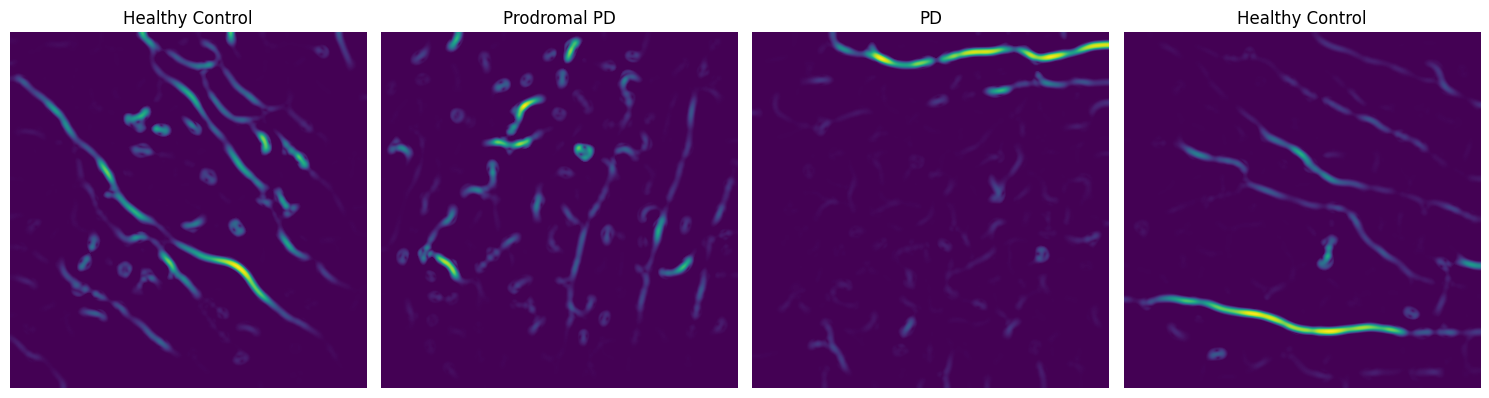

Total number of images in this dataset:  8320
Total number of classes found in this dataset:  3
Class-wise image count is as follows
Healthy Control    2880
PD                 2720
Prodromal PD       2720
Name: label, dtype: int64


In [6]:
# Display original images and vessel behavior () AND THEN  VESSELNESS BEHAVIOUR FOR THE ACTUAL IMAGES.
NUM_IMAGES = 4
display_images(df, NUM_IMAGES)
data_df = df
num_classes = data_df["label"].nunique()
print("Total number of images in this dataset: ", len(data_df))
print("Total number of classes found in this dataset: ", num_classes)
print("Class-wise image count is as follows")
unique_values_counts = data_df["label"].value_counts()
print(unique_values_counts)

# Preprocessing functions

In [7]:
# IF RAW IMAGES ARE TO BE USED IN CLASSIFICATION
def preprocess_image(image_path, target_size=(224, 224)):
    img = load_img(image_path, color_mode="grayscale", target_size=target_size)
    img = img_to_array(img)
    img = img / 255.0  # Normalize pixel values between 0 and 1
    return img


# IF VESSELNESS IMAGES ARE TO BE USED IN CLASSIFICATION
def preprocess_imageShaprened(image_path, target_size=(224, 224)):
    myinput_image = cv2.imread(image_path)
    mysharpened_image = filters.unsharp_mask(
        myinput_image, radius=3, amount=0.5
    )
    # Resize the image to (224, 224)
    resized_image = transform.resize(mysharpened_image, (224, 224), anti_aliasing=True)
    # Convert the resized image to grayscale
    grayscale_image = color.rgb2gray(resized_image)
    # Expand the dimensions to make it (224, 224, 1)
    grayscale_image = grayscale_image[:, :, None]
    # plt.imshow(myinput_image)
    # plt.imshow(grayscale_image,cmap='gray')
    return grayscale_image

# Read images

In [8]:
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["label"])
class_labels = label_encoder.classes_
print(class_labels)

# X = np.array([preprocess_imageShaprened(path) for path in df['ImagePath']]) # IN CASE VESSELNESS IS TO BE USED (increase time)
X = np.array(
    [preprocess_image(path) for path in df["ImagePath"]]
)  # READ ALL IMAGES INTO ARRAY NAMED "X"
X_rgb = np.repeat(
    X, 3, axis=-1
)  # MAKE SURE EVERY IMAGE IS THREE CHANNEL AS MACHINE LEARNING MODEL EXPECT INPUT IMAGE SHAPE (224,224,3)
y = to_categorical(
    df["label"], num_classes=3
)  # CONVERT AND STORE IMAGE LABELS AS MATHEMATICAL ARRAY INSTEAD OF STRING NAMES

['Healthy Control' 'PD' 'Prodromal PD']


# Train-test split

In [9]:
# X_train, X_temp, y_train, y_temp = train_test_split(
#     X_rgb, y, test_size=0.3, random_state=42
# )
# X_val, X_test, y_val, y_test = train_test_split(
#     X_temp, y_temp, test_size=0.67, random_state=42
# )

#Create a GroupShuffleSplit object
gss = GroupShuffleSplit(n_splits=1, test_size=0.3, random_state=24)

# Split the data into train and temp sets based on the patient column
train_idx, temp_idx = next(gss.split(X_rgb, y, groups=df["patient"]))
X_train, y_train = X_rgb[train_idx], y[train_idx]
X_temp, y_temp = X_rgb[temp_idx], y[temp_idx]

# Create another GroupShuffleSplit object for splitting temp into validation and test sets
gss_temp = GroupShuffleSplit(n_splits=1, test_size=0.67, random_state=24)


# Split the temp set into validation and test sets based on the patient column
val_idx, test_idx = next(gss_temp.split(X_temp, y_temp, groups=df.loc[temp_idx, "patient"]))
X_val, y_val = X_temp[val_idx], y_temp[val_idx]
X_test, y_test = X_temp[test_idx], y_temp[test_idx]

# Create model

In [10]:
base_model = VGG16(
    weights="imagenet", include_top=False, input_shape=(224, 224, 3)
)  # TOP LAYER IS REMOVED AS IT HANDLES 1000 CLASSES OF IMAGE NET

# Freeze the convolutional layers of VGG16 (optional)
for layer in base_model.layers:  # FREEZE THE BASE LAYERS TO UTILIZE LAYER WEIGHTS
    layer.trainable = False

# Add my custom layers on top of VGG16
x = Flatten()(base_model.output)  # EXTEND MODEL FOR THIS CUSTOMIZED TASK
x = Dense(128, activation="relu")(
    x
)  # ADD ADDITIONAL DENSE LAYER WITH 128 NEURONS SO THAT MODEL CAN EXTRACT COMPLEX DIFFERENCE/SIMILARITIES AMONG CLASSES
x = BatchNormalization()(x)  # BATCH NORMALIZATION TO AVOID BIASING
x = Dense(64, activation="relu")(x)  # ADDITIONAL DENSE LAYER
x = BatchNormalization()(x)  # BATCH NORMALIZATION LAYER
predictions = Dense(3, activation="softmax")(
    x
)  # LAST LAYER/PREDICTION LAYER WITH THREE NEURONS (NUMBER OF CLASSES IN THIS PROBLEM) and softmax fnction to compute respective probabilities
model = Model(inputs=base_model.input, outputs=predictions)  # MODEL DERIVED
model.summary()  # INSPECT MODEL.SUMMARY FOR LAYER-WISE ARCHITECTURE

2024-03-31 13:15:09.739241: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1926] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 36585 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB MIG 7g.40gb, pci bus id: 0000:47:00.0, compute capability: 8.0


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [12]:
learning_rate = 0.0001  #Define the learning rate control the feature learning speed

# Compile the model with the Adam optimizer and the specified learning rate
optimizer = Adam(learning_rate=learning_rate)
model.compile(
    optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
)

# Fit the model
history = model.fit(
    X_train, y_train, epochs=20, batch_size=64, validation_data=(X_val, y_val)
)

# model.save('TrainedModelGoodOne.h5')

Epoch 1/20


2024-03-31 13:15:23.940562: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:467] Loaded cuDNN version 90000


90/90 [==============================] - 12s 89ms/step - loss: 0.8057 - accuracy: 0.6670 - val_loss: 1.2517 - val_accuracy: 0.2738
Epoch 2/20
90/90 [==============================] - 5s 56ms/step - loss: 0.2642 - accuracy: 0.9398 - val_loss: 1.1258 - val_accuracy: 0.4538
Epoch 3/20
90/90 [==============================] - 4s 46ms/step - loss: 0.1194 - accuracy: 0.9875 - val_loss: 1.1321 - val_accuracy: 0.5587
Epoch 4/20
90/90 [==============================] - 4s 46ms/step - loss: 0.0587 - accuracy: 0.9988 - val_loss: 1.2299 - val_accuracy: 0.5725
Epoch 5/20
90/90 [==============================] - 4s 46ms/step - loss: 0.0380 - accuracy: 0.9998 - val_loss: 1.3811 - val_accuracy: 0.5600
Epoch 6/20
90/90 [==============================] - 4s 46ms/step - loss: 0.0256 - accuracy: 1.0000 - val_loss: 1.4913 - val_accuracy: 0.4950
Epoch 7/20
90/90 [==============================] - 4s 46ms/step - loss: 0.0189 - accuracy: 1.0000 - val_loss: 1.5709 - val_accuracy: 0.5312
Epoch 8/20
90/90 [=====

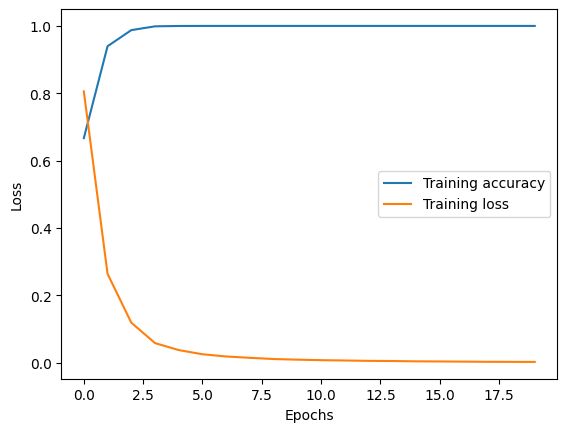

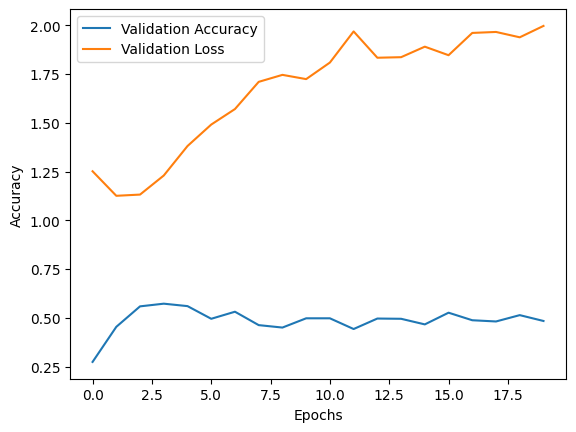

In [13]:
plt.plot(
    history.history["accuracy"], label="Training accuracy"
)  # DISPALY GRAPH FOR TRAINING ACCURACY AND LOSS
plt.plot(history.history["loss"], label="Training loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(
    history.history["val_accuracy"], label="Validation Accuracy"
)  # DISPALY GRAPH FOR VALIDATION ACCURACY AND LOSS
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [14]:
Test_loss, Test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {Test_loss:.4f}")
print(f"Test Accuracy: {Test_accuracy:.4f}")

55/55 [==============================] - 1s 22ms/step - loss: 2.9414 - accuracy: 0.3330
Test Loss: 2.9414
Test Accuracy: 0.3330


55/55 [==============================] - 1s 21ms/step


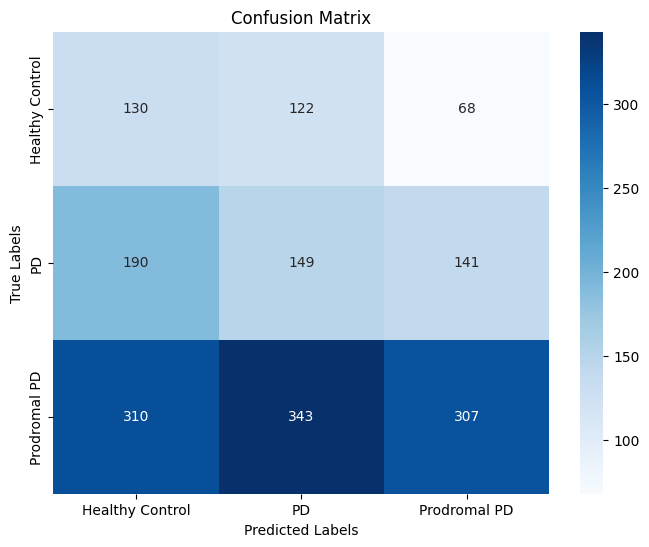

              precision    recall  f1-score   support

           0       0.21      0.41      0.27       320
           1       0.24      0.31      0.27       480
           2       0.59      0.32      0.42       960

    accuracy                           0.33      1760
   macro avg       0.35      0.35      0.32      1760
weighted avg       0.43      0.33      0.35      1760



In [15]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()


# Get predicted labels for the test set
y_pred = model.predict(
    X_test
)  # PERFORM PREDICTION FOR EVERY SINGLE IMAGE I.E. OBTAIN THREE CLASS PROBABILITY
y_pred_classes = np.argmax(
    y_pred, axis=1
)  # DETERMINE THE PREDICTED CLASS LABEL BY CHECKING HIGHEST PROBABILITY CLASS
y_true_classes = np.argmax(
    y_test, axis=1
)  # LOG THE ACUAL/TRUEE CLASS LABEL FOR THIS PARTICULA IMAGE FROM GROUND TRUTH REFERENCE

# Decode the class labels
class_names3 = label_encoder.classes_  # RETRIEVE TRUE CLASS NAMES FROM ENCODED LABELS
# Call the function to plot the confusion matrix
plot_confusion_matrix(
    y_true_classes, y_pred_classes, class_names3
)  # DISPLAY CONFUSION MATRIX BASED PERFORMANCE FOR THREE CLASSES WITH APPROPRIATE CLASS LABELS
# Generate the classification report
report = classification_report(
    y_true_classes, y_pred_classes
)  # GENERATE DETAILED CLASS-WISE CLASSIFICATION REPORT FOR THE TEST DATA
# Print the classification report
print(report)

1/1 [==============================] - 0s 495ms/step
Accuracy: 0.6
1/1 [==============================] - 0s 251ms/step


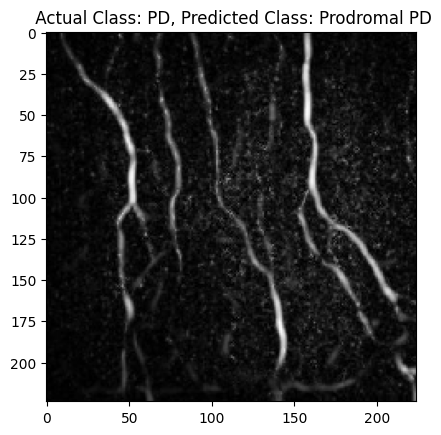

1/1 [==============================] - 0s 18ms/step


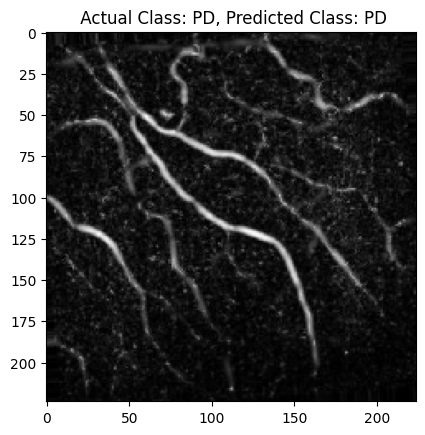

1/1 [==============================] - 0s 18ms/step


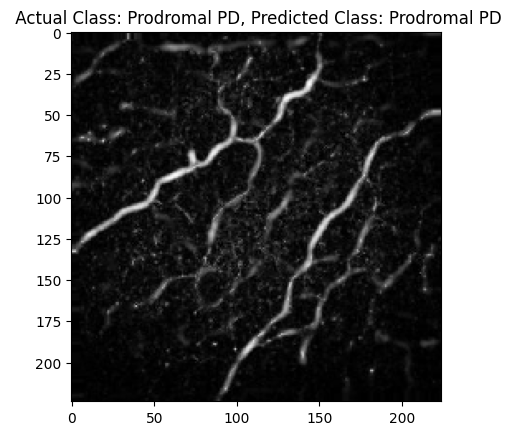

1/1 [==============================] - 0s 18ms/step


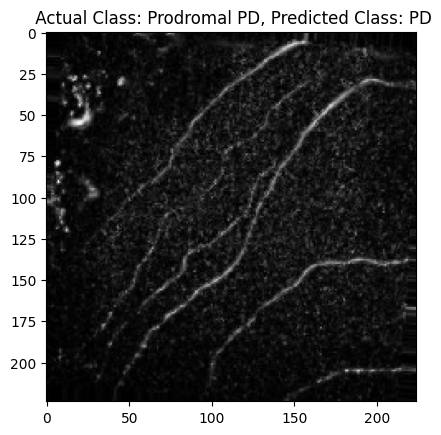

1/1 [==============================] - 0s 18ms/step


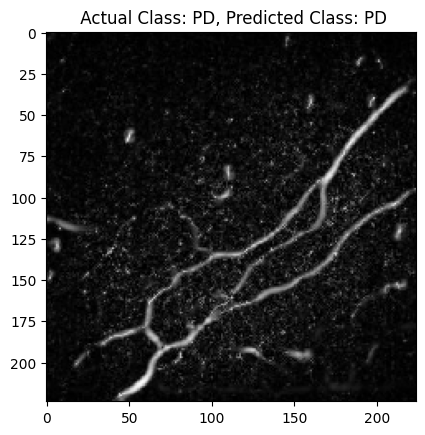

Accuracy: 0.6


In [16]:
shuffled_df = df.sample(frac=1, random_state=42).reset_index(
    drop=True
)  #       PERFORM SHUFFLING OF ALL RECORDS JUST TO OBSERVE RESULTS
shuffled_df = shuffled_df.sample(n=5, random_state=42).reset_index(
    drop=True
)  # PICK DESIRED NUMBER OF RECORD TO CONFIRM RESULTS BY DISPLAY

################################################################################################################################################
newX = np.array(
    [preprocess_image(path) for path in shuffled_df["ImagePath"]]
)  # RETRIEVE IMAGE FROM FOLDER AND PLACE IN ARRAY
newX_rgb = np.repeat(newX, 3, axis=-1)  # MAKE IMAGE 3-CHANNEL AS PER MODEL REQUIREMENT
newy = to_categorical(
    shuffled_df["label"], num_classes=3
)  # Assuming there are 3 classes# CONVERT STRING LABELS INTO THREE NUMERIC LABELS

################################################################################################################################################
allpreds = model.predict(newX_rgb)  # PERFORM PREDICTION USING TRAINED MODEL
finalallpreds = np.argmax(
    allpreds, axis=1
)  # FIND WHICH CLASS HAS BEEN PREDICTED BY MODEL BY CJECKING THE HIGHEST PROBABILITY CLASS
finalnewy = np.argmax(newy, axis=1)
correct_predictions = np.sum(
    finalallpreds == finalnewy
)  # COMPARE MODEL OUTCOME WITH THE ACTUAL /TRUE LABELS OF IMAGES
accuracy = correct_predictions / len(finalnewy)
print("Accuracy:", accuracy)  # DISPLAY ACCURACY
################################################################################################################################################
predictions_list = []
for counter in range(len(newX_rgb)):
    img_array = newX_rgb[counter]  # READ ONE PARTICULAR IMAGE
    actual_gt = newy[counter]  # RECORD TRUE LABEL/REFERENCE LABEL
    img_array = np.expand_dims(
        img_array, axis=0
    )  # APPEND DIMENSION TO MAKE IMAGE (1,224,224,3)
    this_prediction = model.predict(img_array)  # OBTAIN PREDICTION FOR SINGLE IMAGE
    pred_class = np.argmax(
        this_prediction
    )  # FIND THE HIGHEST PROBABILITY CLASS DETECTED
    actual_class = np.argmax(actual_gt)  # FIND TRUE CLASS FROM REFERENCE
    predictions_list.append(
        pred_class
    )  # APPEND THE CURRENT OUTPUT TO THE END OF LIST FOR COMPARISON
    plt.imshow(img_array[0])  # DIAPLAY IMAGE WITH TITLE PREDICTED VERSUS ACTUAL
    plt.title(
        " Actual Class: "
        + str(class_labels[np.argmax(actual_gt)])
        + ", Predicted Class: "
        + str(class_labels[pred_class])
    )
    plt.show()


finalnewy = np.argmax(newy, axis=1)
correct_predictions = np.sum(
    predictions_list == finalnewy
)  # COMPARE TWO LIST FOR SIMILARITY/ACCURACY
accuracy = correct_predictions / len(finalnewy)
print("Accuracy:", accuracy)